# AgriGuard: AI-Powered Plant Disease Detection Demo

This notebook demonstrates the complete workflow:
1. Loading a trained model
2. Processing input images
3. Classifying diseases
4. Getting recommendations
5. Displaying results with confidence scores


In [12]:
%matplotlib inline
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import json
import os
import sys

# Add src directory to path
sys.path.append('src')
from model import build_model
from recommend import get_recommendation
from utils import calculate_sha256

# Configuration
BASE_DIR = os.getcwd()
MODEL_PATH = os.path.join(BASE_DIR, 'models/agriguard_model.pth')
CLASS_INDICES_PATH = os.path.join(BASE_DIR, 'models/class_indices.json')

print("AgriGuard Demo - Plant Disease Detection")
print("=" * 50)


AgriGuard Demo - Plant Disease Detection


## Step 1: Load Model and Class Indices


In [13]:
# Load class indices
with open(CLASS_INDICES_PATH, 'r') as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

print(f"Loaded {num_classes} classes")
print(f"Sample classes: {list(class_to_idx.keys())[:5]}...")


Loaded 38 classes
Sample classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...


In [14]:
# Load model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = build_model(num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()
print("Model loaded successfully!")


Using device: mps
Model loaded successfully!


## Step 2: Define Image Processing Function


In [15]:
def preprocess_image(image_path):
    """Preprocess image for model input."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    return input_tensor, image

def classify_image(model, input_tensor):
    """Classify image and return predictions."""
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class_index = predicted.item()
    predicted_class_name = idx_to_class[predicted_class_index]
    confidence_score = confidence.item()
    
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probabilities, 3)
    top3_predictions = [
        (idx_to_class[idx.item()], prob.item())
        for idx, prob in zip(top3_indices[0], top3_probs[0])
    ]
    
    return predicted_class_name, confidence_score, top3_predictions


## Step 3: Classify an Image

Let's test with a sample image from the test set.


Image Integrity Check (SHA256): 0cdb5a08c6cffb49...


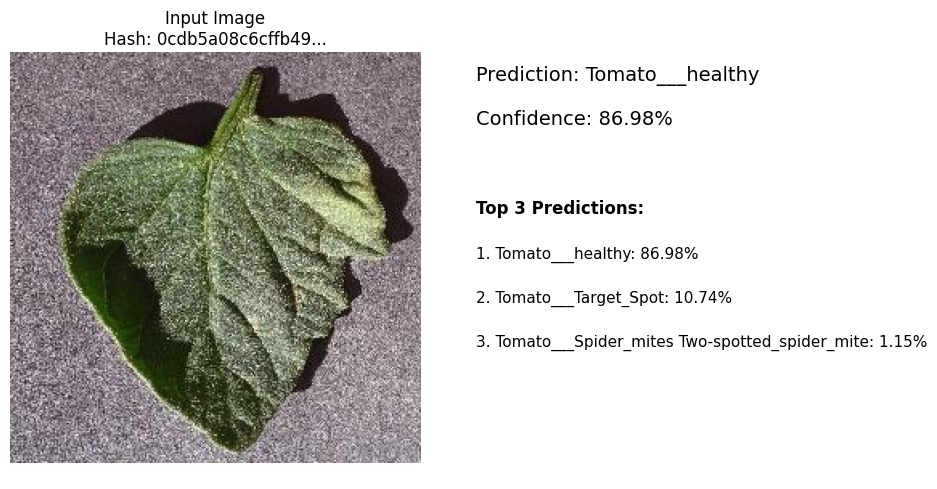


CLASSIFICATION RESULT
Predicted Class: Tomato___healthy
Confidence: 86.98%

Top 3 Predictions:
  1. Tomato___healthy: 86.98%
  2. Tomato___Target_Spot: 10.74%
  3. Tomato___Spider_mites Two-spotted_spider_mite: 1.15%


In [ ]:
# Example: Test with a sample image
test_image_path = "data/test/TomatoHealthy1.JPG"  # Change this to any test image

# Verify image integrity
file_hash = calculate_sha256(test_image_path)
print(f"Image Integrity Check (SHA256): {file_hash[:16]}...")

# Preprocess and classify
input_tensor, original_image = preprocess_image(test_image_path)
predicted_class, confidence, top3 = classify_image(model, input_tensor)

# Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title(f"Input Image\nHash: {file_hash[:16]}...")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.text(0.1, 0.9, f"Prediction: {predicted_class}", fontsize=14, transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f"Confidence: {confidence:.2%}", fontsize=14, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, "Top 3 Predictions:", fontsize=12, weight='bold', transform=plt.gca().transAxes)
for i, (class_name, prob) in enumerate(top3):
    plt.text(0.1, 0.5 - i*0.1, f"{i+1}. {class_name}: {prob:.2%}", fontsize=11, transform=plt.gca().transAxes)
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION RESULT")
print("="*60)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2%}")
print(f"\nTop 3 Predictions:")
for i, (class_name, prob) in enumerate(top3, 1):
    print(f"  {i}. {class_name}: {prob:.2%}")


## Step 4: Get Agricultural Recommendations


In [17]:
# Get recommendation for the predicted class
recommendation = get_recommendation(predicted_class)

print("\n" + "="*60)
print("AGRICULTURAL RECOMMENDATION")
print("="*60)
print(f"\nFor: {predicted_class}")
print(f"\nRecommendation:\n{recommendation}")



AGRICULTURAL RECOMMENDATION

For: Tomato___healthy

Recommendation:
Your tomato plant looks healthy! Stake or cage for support.


## Step 5: Batch Processing Example

Process multiple images and create a results table.


In [18]:
import pandas as pd
from pathlib import Path

# Process multiple test images
test_dir = Path("data/test")
test_images = list(test_dir.glob("*.JPG"))[:5]  # Process first 5 images

results = []

for img_path in test_images:
    # Verify integrity
    file_hash = calculate_sha256(str(img_path))
    
    # Classify
    input_tensor, _ = preprocess_image(str(img_path))
    predicted_class, confidence, _ = classify_image(model, input_tensor)
    recommendation = get_recommendation(predicted_class)
    
    # Determine if healthy or diseased
    status = "Healthy" if "healthy" in predicted_class.lower() else "Diseased"
    
    results.append({
        "Image": img_path.name,
        "Hash (first 10)": file_hash[:10],
        "Status": status,
        "Predicted Class": predicted_class,
        "Confidence": f"{confidence:.2%}",
        "Recommendation": recommendation[:50] + "..." if len(recommendation) > 50 else recommendation
    })

# Create results table
df = pd.DataFrame(results)
print("\n" + "="*60)
print("BATCH PROCESSING RESULTS")
print("="*60)
print(df.to_string(index=False))



BATCH PROCESSING RESULTS
                 Image Hash (first 10)   Status       Predicted Class Confidence                                        Recommendation
        AppleScab3.JPG      cb9805bf00 Diseased    Apple___Apple_scab     91.97% Apply fungicides like captan or myclobutanil. Rake...
TomatoEarlyBlight2.JPG      4e99de5ba6 Diseased  Tomato___Late_blight     52.69% Serious disease. Remove infected plants. Apply fun...
TomatoEarlyBlight3.JPG      4c717c52f6 Diseased Tomato___Early_blight     52.68% Apply fungicides. Mulch to prevent soil splash. Ro...
    PotatoHealthy1.JPG      081328b5e5  Healthy      Potato___healthy     95.62% Your potato plant looks healthy! Hill soil around ...
        AppleScab2.JPG      3743c72197 Diseased    Apple___Apple_scab     99.59% Apply fungicides like captan or myclobutanil. Rake...
